## Hyperparameter Tuning of Models

### 1. Importing Libraries and Reading Data


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from sklearn.feature_selection import RFECV

from sklearn.model_selection import GridSearchCV, validation_curve, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, f1_score,roc_auc_score, roc_curve, auc, precision_score, recall_score

import os
os.chdir('E:/PGP-DSE/Capstone Project/Group 2/OnlineNewsPopularity')

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning) # ignore all future warnings





### 2. Reading the dataset


In [5]:

df = pd.read_csv('ONPClass.csv')

df = df.drop(['url','timedelta'],axis=1)


### 3. Custom Functions:


In [6]:
# function for train test split
def perform_train_test_split(x,y,size):
    return train_test_split(x, y, test_size = size, random_state = 0)


# function for scaling the data for train test split
def std_data(xtrain,xtest):
    sc = StandardScaler()
    scaled = sc.fit(xtrain)
    scaled_train = sc.transform(xtrain)
    scaled_test = sc.transform(xtest)
    return scaled_train, scaled_test

# function to scale whole data
def std_data_n(x):
    sc = StandardScaler()
    scaled = sc.fit_transform(x)
    return scaled


# function to apply rfecv onto the dataset
def apply_rfecv(x,y):

    model = RandomForestClassifier(random_state=0)
    rfecv = RFECV(estimator= model, step = 5, cv=5, scoring='roc_auc')
    rfecv.fit(x, y)
    
    print("Optimal number of features : %d" % rfecv.n_features_)
    
    rfe_features = pd.DataFrame({'features': X.columns, 'rank':rfecv.ranking_}).sort_values(by = 'rank')
    sel_features = rfe_features[rfe_features['rank']==1]['features'].to_list()
    
    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Score")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    return sel_features
    
# function for applying random search cv
def random_search_cv(x,y,model,params):
    RS = RandomizedSearchCV(model, params, cv = 5, scoring = 'roc_auc', random_state = 0)
    RS.fit(x,y)
    return RS.best_params_, RS.best_estimator_, RS.best_score_

# function for applying grid search cv
def grid_search_cv(x,y,model,params):
    GS = GridSearchCV(model, params, cv = 5, scoring = 'roc_auc')
    GS.fit(x,y)
    return GS.best_params_, GS.best_estimator_, GS.best_score_


# creating an empty dataframe with headers
# this would store the values for evaluation metric
headers=['AUC Train','AUC Test','Acc Train','Acc Test','Pre Train','Pre Test','Re Train','Re Test']
dfObj = pd.DataFrame(columns = headers)


# function to get roc_auc_scores for train and test  
def fit_predict_plot(xtrain,xtest,ytrain,ytest,models):
    
    for name, model in models:
        
        model.fit(xtrain,ytrain)
        
        y_pred_train = model.predict(xtrain)
        y_pred_test = model.predict(xtest)
        
        probas_train = model.predict_proba(xtrain)[:,1]
        probas_test = model.predict_proba(xtest)[:,1]

        model_name = name 
        
        plot_roc_auc_curve(probas_train,probas_test,ytrain,ytest,name)
        
        return get_metrics(ytrain,ytest,y_pred_train,y_pred_test,probas_train,probas_test,model_name)
    
    
# function to plot the roc auc curve
def plot_roc_auc_curve(probas_train,probas_test,y_train,y_test,name):
    
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train,probas_train)

        fpr_test, tpr_test, thresholds_test = roc_curve(y_test,probas_test)

        
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
        plt.plot(fpr_train, tpr_train, color='b', 
                 label=r'Train ROC (AUC = %0.2f )' % (roc_auc_score(y_train,probas_train)),lw=2, alpha=.5)
        plt.plot(fpr_test, tpr_test, color='g', 
                 label=r'Test ROC (AUC = %0.2f )' % (roc_auc_score(y_test,probas_test)),lw=2, alpha=.8)

        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        plt.xlabel('False Positive Rate',fontsize=10)
        plt.ylabel('True Positive Rate',fontsize=10)
        plt.title('ROC of %s' % (name),fontsize=10)
        plt.legend(loc="lower right", prop={'size': 9})
        plt.show()

        

    
# function to get all other metrics
def get_metrics(y_train,y_test,y_pred_train,y_pred_test,probas_train,probas_test,name):
        global dfObj
        print('For Train Data:\n')
        print('Confusion Matrix:\n',confusion_matrix(y_train,y_pred_train))
        print('Classification Report:\n',classification_report(y_train,y_pred_train))
        
        print('\n For Test Data:\n')
        print('Confusion Matrix:\n',confusion_matrix(y_test,y_pred_test))
        print('Classification Report:\n',classification_report(y_test,y_pred_test))

        dfObj.loc[name] = [roc_auc_score(y_train,probas_train), roc_auc_score(y_test,probas_test),
                           accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test),
                           precision_score(y_train, y_pred_train), precision_score(y_test, y_pred_test),
                           recall_score(y_train, y_pred_train), recall_score(y_test, y_pred_test)]
        return dfObj
        

# function for applying various models
def implement_cv(x,y,models):
    final = {}
    results = []
    names = []
    auc = []
    for name,model in models:
        kfold = model_selection.KFold(shuffle=True,n_splits=5,random_state=0)
        cv_results = model_selection.cross_val_score(model,x,y,cv=kfold, scoring='roc_auc')
        results.append((np.abs(cv_results)))
        auc.append(np.mean(results))
        names.append(name)
        print(cv_results)
        final.update({'Model': names , 'roc_auc_score': auc})
    return pd.DataFrame(final)


# dataframe styles
th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#f7f7f9')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '11px')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]

In [7]:
# function to get final table for comparison
def compare_models():
    
    final_scores = dfObj

    final_scores.columns = ['Train','Test','Train','Test','Train','Test','Train','Test']

    headers = pd.MultiIndex.from_product([['ROC_AUC','ACCURACY','PRECISION','RECALL'],['Train','Test']])

    final_scores.columns = headers

    return final_scores
    #final_scores.style.set_table_styles(styles)

    #final_scores['ACCURACY'], final_scores['ACCURACY'].plot(kind ='bar')

In [8]:
# run only if required 
dfObj.drop(dfObj.index, inplace=True)

## Using the features obtained from RFECV

In [9]:
top42 = ['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'num_hrefs',
       'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel_is_entertainment',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_min_max',
       'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'self_reference_min_shares',
       'self_reference_max_shares', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_saturday',
       'is_weekend', 'LDA_00', 'LDA_01', 'LDA_03', 'LDA_04',
       'global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rate_negative_words',
       'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity',
       'min_positive_polarity', 'max_positive_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_sentiment_polarity']

In [10]:
X = df[top42]

Y = df['class']

X_train, X_test, y_train, y_test = perform_train_test_split(X,Y,0.3) # splitting the dataset

train, test = std_data(X_train, X_test) # standardizing the train and test sets

X.shape, X_train.shape

((39644, 42), (27750, 42))

## Finding Best Tuned Decision Tree

1st Parameters:

{'max_depth': sp_randint(3,17), 'min_samples_split': sp_randint(2,20), 'min_samples_leaf': sp_randint(2,15), 'criterion': ['gini', 'entropy']} 

we get the best parameters like:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 7}

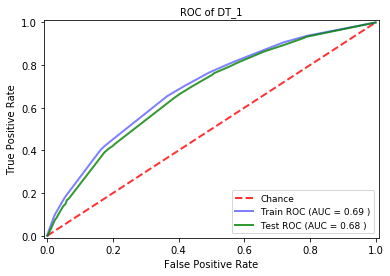

For Train Data:

[[8903 5107]
 [4757 8983]]

 For Test Data:

[[3748 2324]
 [2085 3737]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
DT_1,0.693814,0.676088,0.644541,0.629309,0.637544,0.616565,0.653785,0.641876


In [10]:
dt1_param = {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 7}

DT1 = DecisionTreeClassifier(**dt1_param, random_state = 0)

models = []
models.append(('DT_1', DT1))

fit_predict_plot(train, test, y_train, y_test, models) # implementing the model

2nd Parameters:

{'max_depth': sp_randint(3,13), 'min_samples_split': sp_randint(2,15), 'min_samples_leaf': sp_randint(2,11), 'criterion': ['gini', 'entropy']} 

we get the best parameters like {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 9} 

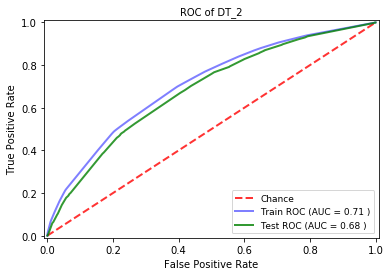

For Train Data:

[[8499 5511]
 [4169 9571]]

 For Test Data:

[[3546 2526]
 [1863 3959]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
DT_1,0.693814,0.676088,0.644541,0.629309,0.637544,0.616565,0.653785,0.641876
DT_2,0.707696,0.682846,0.651171,0.630990,0.634598,0.610486,0.696579,0.680007


In [11]:
dt2_param = {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 9} 

DT2 = DecisionTreeClassifier(**dt2_param, random_state = 0)

models = []
models.append(('DT_2', DT2))

fit_predict_plot(train, test, y_train, y_test, models) # implementing the model

3rd Parameters:
    
{'max_depth': sp_randint(3,10), 'min_samples_split': sp_randint(2,11), 'min_samples_leaf': sp_randint(2,7), 'criterion': ['gini', 'entropy']} 

we get the best parameters like {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 10} 

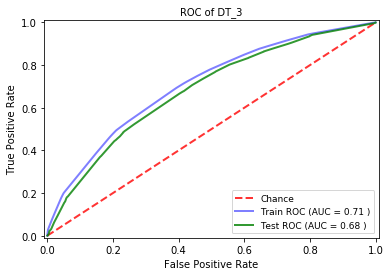

For Train Data:

[[8502 5508]
 [4217 9523]]

 For Test Data:

[[3558 2514]
 [1880 3942]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
DT_1,0.693814,0.676088,0.644541,0.629309,0.637544,0.616565,0.653785,0.641876
DT_2,0.707696,0.682846,0.651171,0.630990,0.634598,0.610486,0.696579,0.680007
DT_3,0.706306,0.681636,0.649550,0.630570,0.633557,0.610595,0.693086,0.677087


In [12]:
dt3_param = {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 10}

DT3 = DecisionTreeClassifier(**dt3_param, random_state = 0)

models = []
models.append(('DT_3', DT3))

fit_predict_plot(train, test, y_train, y_test, models) # implementing the model

4th Parameters:
    
{'max_depth': sp_randint(3,7), ` 'min_samples_split': sp_randint(2,5), 'min_samples_leaf': sp_randint(2,7), 'criterion': ['gini', 'entropy']} 
    
we get the best parameters like {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 3}

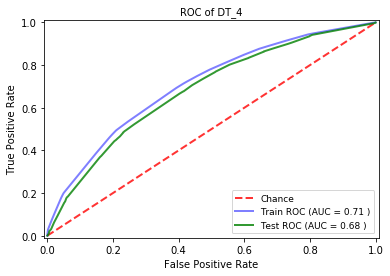

For Train Data:

[[8504 5506]
 [4218 9522]]

 For Test Data:

[[3558 2514]
 [1882 3940]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
DT_1,0.693814,0.676088,0.644541,0.629309,0.637544,0.616565,0.653785,0.641876
DT_2,0.707696,0.682846,0.651171,0.630990,0.634598,0.610486,0.696579,0.680007
DT_3,0.706306,0.681636,0.649550,0.630570,0.633557,0.610595,0.693086,0.677087
DT_4,0.706383,0.681442,0.649586,0.630402,0.633617,0.610474,0.693013,0.676743


In [13]:
dt4_param = {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 3}

DT4 = DecisionTreeClassifier(**dt4_param, random_state = 0)

models = []
models.append(('DT_4', DT4))

fit_predict_plot(train, test, y_train, y_test, models) # implementing the model

5th Parameters:
    
{'max_depth': sp_randint(3,20), 'min_samples_split': sp_randint(2,25), 'min_samples_leaf': sp_randint(2,17), 'criterion': ['gini', 'entropy']} 

we get the best parameters like:{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 19}

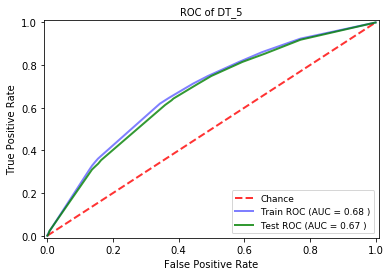

For Train Data:

[[9206 4804]
 [5230 8510]]

 For Test Data:

[[3892 2180]
 [2251 3571]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
DT_1,0.693814,0.676088,0.644541,0.629309,0.637544,0.616565,0.653785,0.641876
DT_2,0.707696,0.682846,0.651171,0.630990,0.634598,0.610486,0.696579,0.680007
DT_3,0.706306,0.681636,0.649550,0.630570,0.633557,0.610595,0.693086,0.677087
DT_4,0.706383,0.681442,0.649586,0.630402,0.633617,0.610474,0.693013,0.676743
DT_5,0.679497,0.668259,0.638414,0.627459,0.639177,0.620935,0.619360,0.613363


In [15]:
dt5_param = {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 19}

DT5 = DecisionTreeClassifier(**dt5_param, random_state = 0)

models = []
models.append(('DT_5', DT5))

fit_predict_plot(train, test, y_train, y_test, models) # implementing the model

In [16]:
compare_models()

### From all the above models, selecting DT_2 as final tuned model

## Finding Best Tuned Random Forest

1st Parameters:
    
{'n_estimators': sp_randint(3,10), 'criterion': ['gini', 'entropy'], 'max_depth': sp_randint(2,10),
  'min_samples_split': sp_randint(2,9), 'min_samples_leaf': sp_randint(2,10)} 
    
we get these best parameters {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 9} 

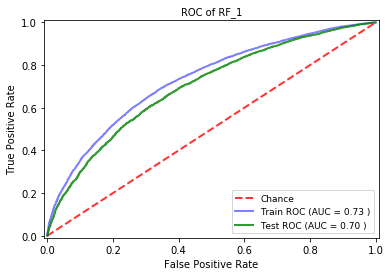

For Train Data:

[[9537 4473]
 [4627 9113]]

 For Test Data:

[[4026 2046]
 [2168 3654]]


ROC_AUC            ACCURACY           PRECISION              RECALL  \
         Train      Test     Train      Test     Train      Test     Train   
RF_1  0.730784  0.699953  0.672072  0.645704  0.670764  0.641053  0.663246   

                
          Test  
RF_1  0.627619

In [18]:
rf1_param =  {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 9}

RF1 = RandomForestClassifier(**rf1_param, random_state = 0)

models = []
models.append(('RF_1',RF1))

fit_predict_plot(train,test,y_train,y_test,models)

2nd Parameters:
    
{'n_estimators': sp_randint(3,9), 'criterion': ['gini', 'entropy'], 'max_depth': sp_randint(2,7), 'min_samples_split': sp_randint(2,9), 'min_samples_leaf': sp_randint(2,7)} 

we get these best parameters {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 6}

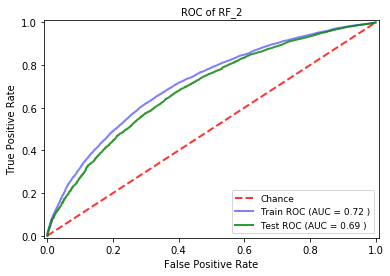

For Train Data:

[[9417 4593]
 [4837 8903]]

 For Test Data:

[[3941 2131]
 [2175 3647]]


ROC_AUC            ACCURACY           PRECISION              RECALL  \
         Train      Test     Train      Test     Train      Test     Train   
RF_1  0.730784  0.699953  0.672072  0.645704  0.670764  0.641053  0.663246   
RF_2  0.715076  0.690507  0.660180  0.637969  0.659677  0.631187  0.647962   

                
          Test  
RF_1  0.627619  
RF_2  0.626417

In [19]:
rf2_param = {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 6}

RF2 = RandomForestClassifier(**rf2_param, random_state = 0)

models = []
models.append(('RF_2',RF2))

fit_predict_plot(train,test,y_train,y_test,models)

3rd Parameters:
    
{'n_estimators': sp_randint(3,7), 'criterion': ['gini', 'entropy'], 'max_depth': sp_randint(2,5), 
 'min_samples_split': sp_randint(2,7), 'min_samples_leaf': sp_randint(2,5)} 

we get these best parameters {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 5}

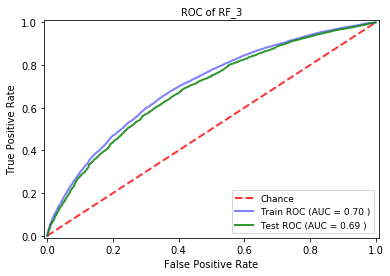

For Train Data:

[[9284 4726]
 [4971 8769]]

 For Test Data:

[[3927 2145]
 [2182 3640]]


ROC_AUC            ACCURACY           PRECISION              RECALL  \
         Train      Test     Train      Test     Train      Test     Train   
RF_1  0.730784  0.699953  0.672072  0.645704  0.670764  0.641053  0.663246   
RF_2  0.715076  0.690507  0.660180  0.637969  0.659677  0.631187  0.647962   
RF_3  0.703152  0.685429  0.650559  0.636203  0.649796  0.629213  0.638210   

                
          Test  
RF_1  0.627619  
RF_2  0.626417  
RF_3  0.625215

In [20]:
rf3_param = {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 5}

RF3 = RandomForestClassifier(**rf3_param, random_state = 0)

models = []
models.append(('RF_3',RF3))

fit_predict_plot(train,test,y_train,y_test,models)

In [21]:
compare_models()

### From all the above models, selecting RF_1 as final tuned model

### Tuned Random Forest

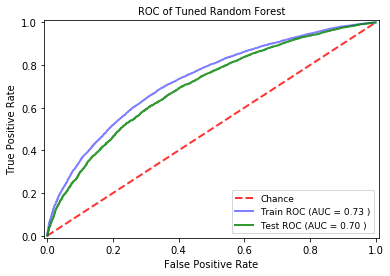

For Train Data:

Confusion Matrix:
 [[9537 4473]
 [4627 9113]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.68      0.68     14010
           1       0.67      0.66      0.67     13740

    accuracy                           0.67     27750
   macro avg       0.67      0.67      0.67     27750
weighted avg       0.67      0.67      0.67     27750


 For Test Data:

Confusion Matrix:
 [[4026 2046]
 [2168 3654]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.66      0.66      6072
           1       0.64      0.63      0.63      5822

    accuracy                           0.65     11894
   macro avg       0.65      0.65      0.65     11894
weighted avg       0.65      0.65      0.65     11894



,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Tuned Random Forest,0.730784,0.699953,0.672072,0.645704,0.670764,0.641053,0.663246,0.627619


In [74]:
rf_param =  {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 9}

tuned_RF = RandomForestClassifier(**rf_param, random_state = 0)

models = []
models.append(('Tuned Random Forest',tuned_RF))

fit_predict_plot(train,test,y_train,y_test,models)



### Tuned Decision Tree

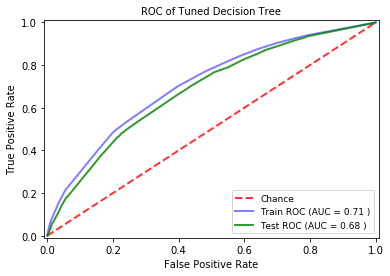

For Train Data:

Confusion Matrix:
 [[8499 5511]
 [4169 9571]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.61      0.64     14010
           1       0.63      0.70      0.66     13740

    accuracy                           0.65     27750
   macro avg       0.65      0.65      0.65     27750
weighted avg       0.65      0.65      0.65     27750


 For Test Data:

Confusion Matrix:
 [[3546 2526]
 [1863 3959]]
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.58      0.62      6072
           1       0.61      0.68      0.64      5822

    accuracy                           0.63     11894
   macro avg       0.63      0.63      0.63     11894
weighted avg       0.63      0.63      0.63     11894



,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Tuned Random Forest,0.730784,0.699953,0.672072,0.645704,0.670764,0.641053,0.663246,0.627619
Tuned Decision Tree,0.707696,0.682846,0.651171,0.630990,0.634598,0.610486,0.696579,0.680007


In [75]:
dt_param = {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 9} 

tuned_DT = DecisionTreeClassifier(**dt_param, random_state = 0)

models = []
models.append(('Tuned Decision Tree', tuned_DT))

fit_predict_plot(train, test, y_train, y_test, models) # implementing the model

## Comparing tuned Models

In [76]:
compare_models()

ROC_AUC            ACCURACY           PRECISION  \
                        Train      Test     Train      Test     Train   
Tuned Random Forest  0.730784  0.699953  0.672072  0.645704  0.670764   
Tuned Decision Tree  0.707696  0.682846  0.651171  0.630990  0.634598   

                                 RECALL            
                         Test     Train      Test  
Tuned Random Forest  0.641053  0.663246  0.627619  
Tuned Decision Tree  0.610486  0.696579  0.680007

## Tuning AB_DT and AB_RF Models

In [106]:
# base estimators for AB_DT and AB_RF
DT = DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 10, min_samples_split = 11, random_state = 0)

RF = RandomForestClassifier(max_depth = 3, min_samples_split = 11, min_samples_leaf = 10,random_state = 0)

## Tuning AB_DT


In [16]:
AB_DT = AdaBoostClassifier(base_estimator = DT, random_state = 0) 

abdt_params = {'n_estimators':np.arange(10,14,1)}

abdtparam, abdtestimator, abdtscore = random_search_cv(train,y_train,AB_DT,abdt_params)

print('Best parameters are:\n', abdtparam)


C:\Users\Ankita\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best parameters are:
 {'n_estimators': 12}



abdt_params = {'n_estimators':np.arange(10,50,1)}

Best parameters are: {'n_estimators': 14}

Boosted Decision Tree (Tuned)	0.737251	0.700035	0.672685	0.644695	0.670524	0.637066	0.666376 0.637066

### ----------------------------------------------------------------------------------

abdt_params = {'n_estimators':np.arange(14,20,1)}

Best parameters are: {'n_estimators': 15}

Boosted Decision Tree (Tuned)	0.738714	0.699923	0.673802	0.644274	0.672226	0.636943	0.665866 0.635520

### ---------------------------------------------------------------------------------

abdt_params = {'n_estimators':np.arange(10,14,1)}

Best parameters are: {'n_estimators': 12}

Boosted Decision Tree (Tuned)	0.733190	0.700118	0.669333	0.643266	0.666278	0.634980	0.665502 0.637925

### Tuned AB_DT 

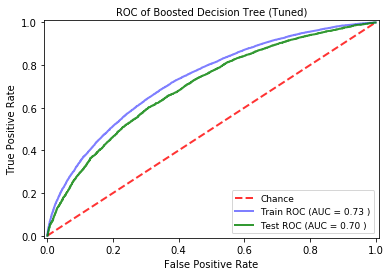

For Train Data:

[[9430 4580]
 [4596 9144]]

 For Test Data:

[[3937 2135]
 [2108 3714]]


ROC_AUC            ACCURACY            \
                                  Train      Test     Train      Test   
Tuned Random Forest            0.730784  0.699953  0.672072  0.645704   
Tuned Decision Tree            0.707696  0.682846  0.651171  0.630990   
Boosted Decision Tree (Tuned)  0.733190  0.700118  0.669333  0.643266   

                              PRECISION              RECALL            
                                  Train      Test     Train      Test  
Tuned Random Forest            0.670764  0.641053  0.663246  0.627619  
Tuned Decision Tree            0.634598  0.610486  0.696579  0.680007  
Boosted Decision Tree (Tuned)  0.666278  0.634980  0.665502  0.637925

In [17]:
AB_DT = AdaBoostClassifier(base_estimator = DT, n_estimators = 12, random_state = 0) 

models = []
models.append(('Boosted Decision Tree (Tuned)',AB_DT))

fit_predict_plot(train,test,y_train,y_test,models)


## Tuning AB_RF

In [23]:
AB_RF = AdaBoostClassifier(base_estimator = RF, random_state = 0) 

abrf_params = {'n_estimators':np.arange(10,13,1)}

abrfparam, abrfestimator, abrfscore = random_search_cv(train,y_train,AB_RF,abrf_params)

print('Best parameters are:\n', abrfparam)


C:\Users\Ankita\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best parameters are:
 {'n_estimators': 12}


abdt_params = {'n_estimators':np.arange(10,50,1)}

Best parameters are: {'n_estimators': 13} 

Boosted Random forest (Tuned)	0.750354	0.719674	0.684108	0.658399	0.683814	0.651979	0.673362	0.648059

### ------------------------------------------------------------------------------

abrf_params = {'n_estimators':np.arange(14,20,1)}

Best parameters are: {'n_estimators': 19}

Boosted Random forest (Tuned)	0.759770	0.720901	0.691820	0.658651	0.691864	0.652686	0.680786	0.646857

### ------------------------------------------------------------------------------

abrf_params = {'n_estimators':np.arange(10,13,1)}

Best parameters are: {'n_estimators': 12}

Boosted Random forest (Tuned)	0.748677	0.719385	0.681694	0.658988	0.681593	0.652663	0.670233	0.648403

### Tuned AB_RF 

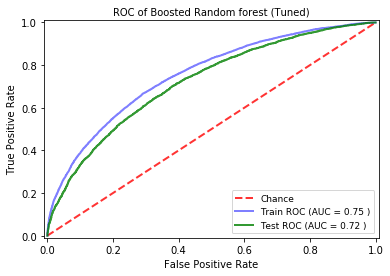

For Train Data:

[[9762 4248]
 [4451 9289]]

 For Test Data:

[[4068 2004]
 [2055 3767]]


ROC_AUC            ACCURACY            \
                                  Train      Test     Train      Test   
Tuned Random Forest            0.730784  0.699953  0.672072  0.645704   
Tuned Decision Tree            0.707696  0.682846  0.651171  0.630990   
Boosted Decision Tree (Tuned)  0.733190  0.700118  0.669333  0.643266   
Boosted Random forest (Tuned)  0.753678  0.720130  0.686523  0.658735   

                              PRECISION              RECALL            
                                  Train      Test     Train      Test  
Tuned Random Forest            0.670764  0.641053  0.663246  0.627619  
Tuned Decision Tree            0.634598  0.610486  0.696579  0.680007  
Boosted Decision Tree (Tuned)  0.666278  0.634980  0.665502  0.637925  
Boosted Random forest (Tuned)  0.686193  0.652746  0.676055  0.647029

In [28]:
AB_RF = AdaBoostClassifier(base_estimator = RF, n_estimators = 15, random_state = 0) 

models = []
models.append(('Boosted Random forest (Tuned)', AB_RF))

fit_predict_plot(train, test, y_train, y_test, models) # implementing the model


## Tuning Gradient Boost


In [45]:
X = df.drop(['class','avg_negative_polarity','min_negative_polarity','max_negative_polarity','abs_title_subjectivity',
            'weekday_is_friday'],axis = 1 )

Y = df['class']

X_scaled = std_data_n(X)

**keeping constant learning rate at 0.1**

In [42]:
# Maximum number of levels in tree
n_estimators = np.arange(100,110,5)

gb_params = {'n_estimators': n_estimators}

GB =  GradientBoostingClassifier(random_state = 0)

gbparam, gbestimator, gbscore = random_search_cv(X_scaled,Y,GB,gb_params)

print('Best parameters for Gradient Boost are:\n', gbparam)

C:\Users\Ankita\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best parameters for Gradient Boost are:
 {'n_estimators': 100}


n_estimators = np.arange(20,40,10)

Best parameters for Gradient Boost are: {'n_estimators': 30}

### ---------------------------------------------------------------------------
    
n_estimators = np.arange(40,60,10)

Best parameters for Gradient Boost are: {'n_estimators': 40}

### ---------------------------------------------------------------------------

n_estimators = np.arange(30,50,5)

Best parameters for Gradient Boost are: {'n_estimators': 35}

### ---------------------------------------------------------------------------

n_estimators = np.arange(50,70,1)

Best parameters for Gradient Boost are: {'n_estimators': 58}

### ---------------------------------------------------------------------------

n_estimators = np.arange(60,70,3)

Best parameters for Gradient Boost are: {'n_estimators': 69}

### ---------------------------------------------------------------------------

n_estimators = np.arange(100,110,3)

Best parameters for Gradient Boost are: {'n_estimators': 100}

**using the optimal values of learning rate and no. of estimators for tuning tree parameters**

In [46]:
# Maximum number of levels in tree
max_depth = np.arange(3,15,2)

# Minimum number of samples required to split a node
min_samples_split = np.arange(10,50,10)

# Minimum number of samples required at each leaf node
min_samples_leaf = np.arange(10,30,10)

gb_params = {'max_depth': max_depth, 
             'min_samples_leaf': min_samples_leaf, 
             'min_samples_split': min_samples_split}

GB =  GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.1, random_state = 0)

gbparam, gbestimator, gbscore = random_search_cv(X_scaled,Y,GB,gb_params)

print('Best parameters for Gradient Boost are:\n', gbparam)

Best parameters for Gradient Boost are:
 {'min_samples_split': 10, 'min_samples_leaf': 20, 'max_depth': 3}


For 30 estimators:
gb_params = {'max_depth': np.arange(3,15,2), 'min_samples_leaf': np.arange(10,30,10), 'min_samples_split': np.arange(10,50,10)}

Best tree parameters for Gradient Boost are: {'min_samples_split': 30, 'min_samples_leaf': 10, 'max_depth': 5}

### ---------------------------------------------------------------------------

For 35 estimators:
gb_params = {'max_depth': np.arange(3,15,2), 'min_samples_leaf': np.arange(10,30,10), 'min_samples_split': np.arange(10,50,10)}

Best parameters for Gradient Boost are:
 {'min_samples_split': 10, 'min_samples_leaf': 20, 'max_depth': 3}

### ---------------------------------------------------------------------------

For 40 estimators:
gb_params = {'max_depth': np.arange(3,15,2), 'min_samples_leaf': np.arange(10,30,10), 'min_samples_split': np.arange(10,50,10)}

Best parameters for Gradient Boost are:
 {'min_samples_split': 10, 'min_samples_leaf': 20, 'max_depth': 3}
 
### ---------------------------------------------------------------------------
 

For 58 estimators:
gb_params = {'max_depth': np.arange(3,15,2), 'min_samples_leaf': np.arange(10,30,10), 'min_samples_split': np.arange(10,50,10)}

Best parameters for Gradient Boost are: {'min_samples_split': 10, 'min_samples_leaf': 20, 'max_depth': 3}

### ---------------------------------------------------------------------------

For 60 estimators:
gb_params = {'max_depth': np.arange(3,15,2), 'min_samples_leaf': np.arange(10,30,10), 'min_samples_split': np.arange(10,50,10)}

Best parameters for Gradient Boost are: {'min_samples_split': 10, 'min_samples_leaf': 20, 'max_depth': 3}

### ---------------------------------------------------------------------------

For 69 estimators:
gb_params = {'max_depth': np.arange(3,15,2), 'min_samples_leaf': np.arange(10,30,10), 'min_samples_split': np.arange(10,50,10)}

Best parameters for Gradient Boost are: {'min_samples_split': 10, 'min_samples_leaf': 20, 'max_depth': 3}



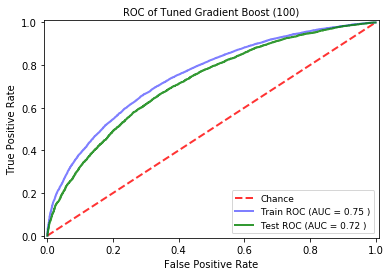

For Train Data:

[[9776 4234]
 [4547 9193]]

 For Test Data:

[[4088 1984]
 [2062 3760]]


ROC_AUC            ACCURACY           PRECISION  \
                                Train      Test     Train      Test     Train   
Tuned Random Forest          0.730784  0.699953  0.672072  0.645704  0.670764   
Tuned Decision Tree          0.707696  0.682846  0.651171  0.630990  0.634598   
Tuned Gradient Boost         0.741597  0.715988  0.675784  0.657474  0.676464   
Boosted Decision Tree        0.932703  0.650173  0.839748  0.616109  0.847662   
Boosted Random Forest        0.954982  0.707818  0.879387  0.652178  0.891863   
Tuned Boosted Decision Tree  0.734103  0.693692  0.668829  0.634606  0.666277   
Tuned Gradient Boost (100)   0.750584  0.718745  0.683568  0.659828  0.684665   

                                         RECALL            
                                 Test     Train      Test  
Tuned Random Forest          0.641053  0.663246  0.627619  
Tuned Decision Tree          0.610486  0.696579  0.680007  
Tuned Gradient Boost         0.651054  0.661645  0.647029  
Boosted Decision Tree        0.608613  0.824527  0.604431  
Boosted Random Forest        0.646905  0.860771  0.637238  
Tuned Boosted Decision Tree  0.625340  0.663464  0.632429  
Tuned Gradient Boost (100)   0.654596  0.669068  0.645826

In [47]:
tuned_GB = GradientBoostingClassifier(n_estimators = 100,learning_rate = 0.1, max_depth = 3, 
                                min_samples_split = 10, min_samples_leaf = 20, random_state = 0)

models = []
models.append(('Tuned Gradient Boost (100)',tuned_GB))

fit_predict_plot(train,test,y_train,y_test,models)

#Tuned Gradient Boost (30)	0.760351	0.713763	0.690378	0.653691	0.693243	0.649517	0.672052	0.635349
#Tuned Gradient Boost (40)	0.73013	0.710981	0.667279	0.654868	0.667808	0.649434	0.652693	0.640845
#Tuned Gradient Boost (58)	0.737791	0.714758	0.672577	0.655541	0.672549	0.648733	0.660116	0.64617
#Tuned Gradient Boost (60)	0.738562	0.714991	0.673766	0.656802	0.673966	0.650104	0.660771	0.647200
#Tuned Gradient Boost (100)	0.750584	0.718745	0.683568	0.659828	0.684665	0.654596	0.669068	0.645826

In [29]:
# run only if required 
dfObj.drop(dfObj.index, inplace=True)

## Final Tuned Boosting Models

In [107]:
X = df[top42]

Y = df['class']

X_train, X_test, y_train, y_test = perform_train_test_split(X,Y,0.3) # splitting the dataset

train, test = std_data(X_train, X_test) # standardizing the train and test sets

X.shape, X_train.shape

((39644, 42), (27750, 42))

### Final Tuned AB_DT

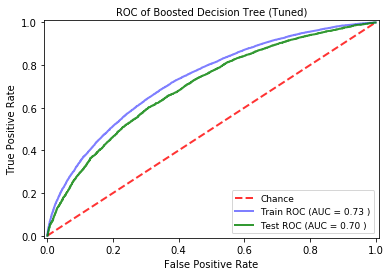

For Train Data:

Confusion Matrix:
 [[9430 4580]
 [4596 9144]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67     14010
           1       0.67      0.67      0.67     13740

    accuracy                           0.67     27750
   macro avg       0.67      0.67      0.67     27750
weighted avg       0.67      0.67      0.67     27750


 For Test Data:

Confusion Matrix:
 [[3937 2135]
 [2108 3714]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.65      0.65      6072
           1       0.63      0.64      0.64      5822

    accuracy                           0.64     11894
   macro avg       0.64      0.64      0.64     11894
weighted avg       0.64      0.64      0.64     11894



,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Boosted Decision Tree (Tuned),0.73319,0.700118,0.669333,0.643266,0.666278,0.63498,0.665502,0.637925


In [108]:
tuned_AB_DT = AdaBoostClassifier(base_estimator = DT, n_estimators = 12, random_state = 0) 

models = []
models.append(('Boosted Decision Tree (Tuned)',tuned_AB_DT))

fit_predict_plot(train,test,y_train,y_test,models)

### Final Tuned AB_RF

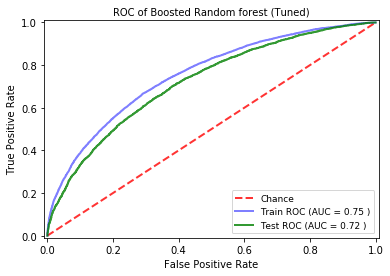

For Train Data:

Confusion Matrix:
 [[9762 4248]
 [4451 9289]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.70      0.69     14010
           1       0.69      0.68      0.68     13740

    accuracy                           0.69     27750
   macro avg       0.69      0.69      0.69     27750
weighted avg       0.69      0.69      0.69     27750


 For Test Data:

Confusion Matrix:
 [[4068 2004]
 [2055 3767]]
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.67      0.67      6072
           1       0.65      0.65      0.65      5822

    accuracy                           0.66     11894
   macro avg       0.66      0.66      0.66     11894
weighted avg       0.66      0.66      0.66     11894



,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Boosted Decision Tree (Tuned),0.733190,0.700118,0.669333,0.643266,0.666278,0.634980,0.665502,0.637925
Boosted Random forest (Tuned),0.753678,0.720130,0.686523,0.658735,0.686193,0.652746,0.676055,0.647029


In [109]:
tuned_AB_RF = AdaBoostClassifier(base_estimator = RF, n_estimators = 15, random_state = 0) 

models = []
models.append(('Boosted Random forest (Tuned)', tuned_AB_RF))

fit_predict_plot(train, test, y_train, y_test, models) # implementing the model

In [80]:
abrfimp = pd.DataFrame({'features':X.columns,'imp':tuned_AB_RF.feature_importances_})
abrfimp.sort_values(by='imp',ascending=False)

,features,imp
18,kw_max_avg,0.064528
17,kw_min_avg,0.059245
19,self_reference_min_shares,0.057651
26,LDA_00,0.052825
2,n_unique_tokens,0.043450
20,self_reference_max_shares,0.037755
30,global_subjectivity,0.036081
25,is_weekend,0.032313
3,num_hrefs,0.031491
27,LDA_01,0.029549


In [81]:
len(abrfimp['features'].tolist())

42

### Final Tuned GB

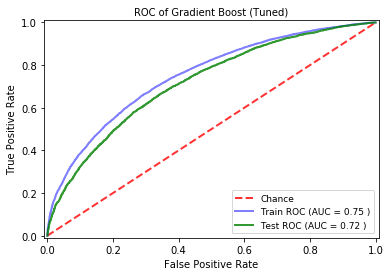

For Train Data:

Confusion Matrix:
 [[9776 4234]
 [4547 9193]]
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.70      0.69     14010
           1       0.68      0.67      0.68     13740

    accuracy                           0.68     27750
   macro avg       0.68      0.68      0.68     27750
weighted avg       0.68      0.68      0.68     27750


 For Test Data:

Confusion Matrix:
 [[4088 1984]
 [2062 3760]]
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.67      0.67      6072
           1       0.65      0.65      0.65      5822

    accuracy                           0.66     11894
   macro avg       0.66      0.66      0.66     11894
weighted avg       0.66      0.66      0.66     11894



,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Boosted Decision Tree (Tuned),0.733190,0.700118,0.669333,0.643266,0.666278,0.634980,0.665502,0.637925
Boosted Random forest (Tuned),0.753678,0.720130,0.686523,0.658735,0.686193,0.652746,0.676055,0.647029
Gradient Boost (Tuned),0.750584,0.718745,0.683568,0.659828,0.684665,0.654596,0.669068,0.645826


In [110]:
tuned_GB = GradientBoostingClassifier(n_estimators = 100,learning_rate = 0.1, max_depth = 3, 
                                min_samples_split = 10, min_samples_leaf = 20, random_state = 0)

models = []
models.append(('Gradient Boost (Tuned)',tuned_GB))

fit_predict_plot(train,test,y_train,y_test,models)

In [83]:
tuned_GB.feature_importances_

array([0.00143399, 0.01423318, 0.03964645, 0.02806102, 0.00415042,
       0.01810732, 0.00373951, 0.00489072, 0.00174298, 0.0647751 ,
       0.0235562 , 0.05341233, 0.0427833 , 0.03549309, 0.0128779 ,
       0.00312055, 0.00764558, 0.07190897, 0.14205786, 0.13224027,
       0.03930383, 0.0013002 , 0.00170639, 0.00067054, 0.00328242,
       0.09195697, 0.03266956, 0.01312972, 0.00485931, 0.01990056,
       0.01951611, 0.00404031, 0.00593699, 0.00504029, 0.00550155,
       0.00316719, 0.00480035, 0.02262096, 0.000778  , 0.00517549,
       0.00791556, 0.00085098])

In [84]:
abgbimp = pd.DataFrame({'features':X.columns,'imp':tuned_GB.feature_importances_})
abgbimp.sort_values(by='imp',ascending=False)

,features,imp
18,kw_max_avg,0.142058
19,self_reference_min_shares,0.132240
25,is_weekend,0.091957
17,kw_min_avg,0.071909
9,data_channel_is_entertainment,0.064775
11,data_channel_is_tech,0.053412
12,data_channel_is_world,0.042783
2,n_unique_tokens,0.039646
20,self_reference_max_shares,0.039304
13,kw_min_min,0.035493


In [85]:
len(abgbimp['features'].tolist())

42

## Comparing Tuned Boosting Models

In [86]:
boosted_tuned_df = compare_models()
boosted_tuned_df

ROC_AUC            ACCURACY            \
                                  Train      Test     Train      Test   
Tuned Random Forest            0.730784  0.699953  0.672072  0.645704   
Tuned Decision Tree            0.707696  0.682846  0.651171  0.630990   
Boosted Decision Tree (Tuned)  0.733190  0.700118  0.669333  0.643266   
Boosted Random forest (Tuned)  0.753678  0.720130  0.686523  0.658735   
Gradient Boost (Tuned)         0.750584  0.718745  0.683568  0.659828   

                              PRECISION              RECALL            
                                  Train      Test     Train      Test  
Tuned Random Forest            0.670764  0.641053  0.663246  0.627619  
Tuned Decision Tree            0.634598  0.610486  0.696579  0.680007  
Boosted Decision Tree (Tuned)  0.666278  0.634980  0.665502  0.637925  
Boosted Random forest (Tuned)  0.686193  0.652746  0.676055  0.647029  
Gradient Boost (Tuned)         0.684665  0.654596  0.669068  0.645826

## Find Important Features

In [87]:
imp_features = []

# provide number of imp features to be obtained
n_feat = 30

def get_imp_features(model,num):
    
    alg = model

    feat_imp = pd.Series(alg.feature_importances_, X.columns).sort_values(ascending=False)
    
    imp_features.append([feat_imp[feat_imp == i].index[0] for i in feat_imp[:num] if i > 0])

    #feat_importances = pd.Series(dt.feature_importances_, index=X.columns)
    
    plt.figure(figsize = (15,5))
    feat_imp.nlargest(num).plot(kind='barh',title='Feature Importances')
    plt.xlabel('Feature Importance Score')
    plt.show()


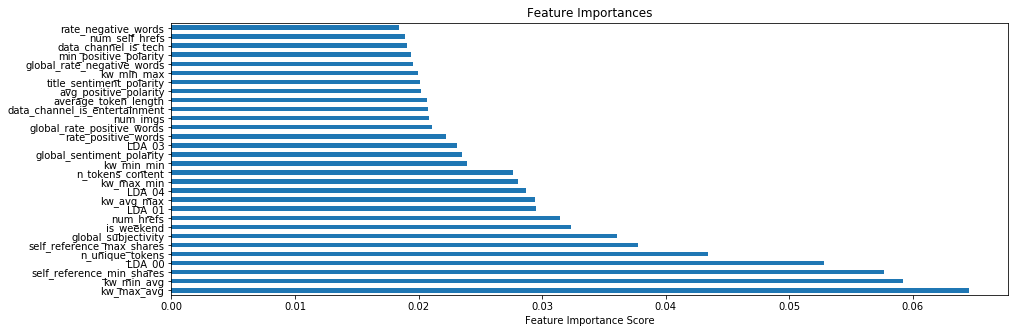

In [88]:
get_imp_features(tuned_AB_RF,n_feat)

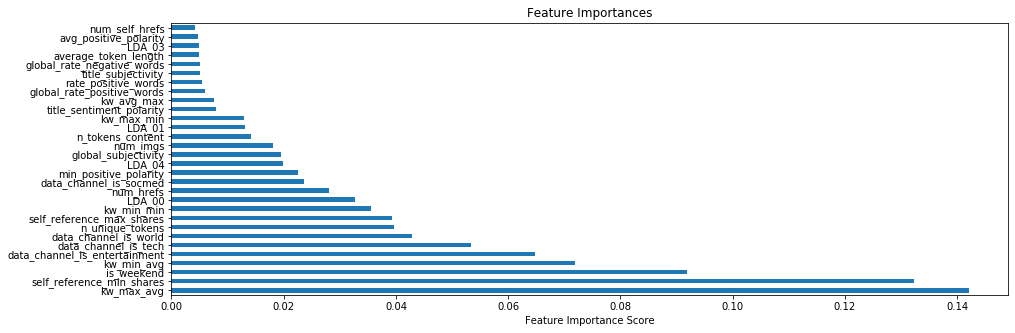

In [89]:
get_imp_features(tuned_GB,n_feat)

In [90]:
print(imp_features)

[['kw_max_avg', 'kw_min_avg', 'self_reference_min_shares', 'LDA_00', 'n_unique_tokens', 'self_reference_max_shares', 'global_subjectivity', 'is_weekend', 'num_hrefs', 'LDA_01', 'kw_avg_max', 'LDA_04', 'kw_max_min', 'n_tokens_content', 'kw_min_min', 'global_sentiment_polarity', 'LDA_03', 'rate_positive_words', 'global_rate_positive_words', 'num_imgs', 'data_channel_is_entertainment', 'average_token_length', 'avg_positive_polarity', 'title_sentiment_polarity', 'kw_min_max', 'global_rate_negative_words', 'min_positive_polarity', 'data_channel_is_tech', 'num_self_hrefs', 'rate_negative_words'], ['kw_max_avg', 'self_reference_min_shares', 'is_weekend', 'kw_min_avg', 'data_channel_is_entertainment', 'data_channel_is_tech', 'data_channel_is_world', 'n_unique_tokens', 'self_reference_max_shares', 'kw_min_min', 'LDA_00', 'num_hrefs', 'data_channel_is_socmed', 'min_positive_polarity', 'LDA_04', 'global_subjectivity', 'num_imgs', 'n_tokens_content', 'LDA_01', 'kw_max_min', 'title_sentiment_polari

In [25]:
trf_top20 = ['kw_max_avg', 'kw_min_avg', 'self_reference_min_shares', 'LDA_00', 'n_unique_tokens', 'self_reference_max_shares', 'global_subjectivity', 'is_weekend', 'num_hrefs', 'LDA_01', 'kw_avg_max', 'LDA_04', 'kw_max_min', 'n_tokens_content', 'kw_min_min', 'global_sentiment_polarity', 'LDA_03', 'rate_positive_words', 'global_rate_positive_words', 'num_imgs']

In [26]:
X = df[trf_top20]

Y = df['class']

X_train, X_test, y_train, y_test = perform_train_test_split(X,Y,0.3) # splitting the dataset

train, test = std_data(X_train, X_test) # standardizing the train and test sets

X.shape, X_train.shape

((39644, 20), (27750, 20))

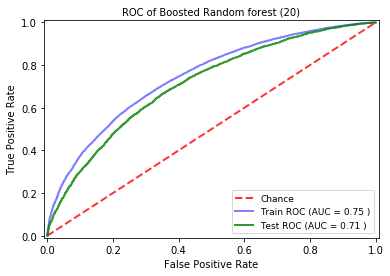

For Train Data:

Confusion Matrix:
 [[9624 4386]
 [4563 9177]]
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.69      0.68     14010
           1       0.68      0.67      0.67     13740

    accuracy                           0.68     27750
   macro avg       0.68      0.68      0.68     27750
weighted avg       0.68      0.68      0.68     27750


 For Test Data:

Confusion Matrix:
 [[4045 2027]
 [2058 3764]]
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.67      0.66      6072
           1       0.65      0.65      0.65      5822

    accuracy                           0.66     11894
   macro avg       0.66      0.66      0.66     11894
weighted avg       0.66      0.66      0.66     11894



ROC_AUC            ACCURACY            \
                                  Train      Test     Train      Test   
Tuned Random Forest            0.730784  0.699953  0.672072  0.645704   
Tuned Decision Tree            0.707696  0.682846  0.651171  0.630990   
Boosted Decision Tree (Tuned)  0.733190  0.700118  0.669333  0.643266   
Boosted Random forest (Tuned)  0.745175  0.711391  0.677514  0.656550   
Gradient Boost (Tuned)         0.750584  0.718745  0.683568  0.659828   
Boosted Random forest (20)     0.745175  0.711391  0.677514  0.656550   

                              PRECISION              RECALL            
                                  Train      Test     Train      Test  
Tuned Random Forest            0.670764  0.641053  0.663246  0.627619  
Tuned Decision Tree            0.634598  0.610486  0.696579  0.680007  
Boosted Decision Tree (Tuned)  0.666278  0.634980  0.665502  0.637925  
Boosted Random forest (Tuned)  0.676620  0.649974  0.667904  0.646513  
Gradient Boost (Tuned)         0.684665  0.654596  0.669068  0.645826  
Boosted Random forest (20)     0.676620  0.649974  0.667904  0.646513

In [27]:
tuned_AB_RF = AdaBoostClassifier(base_estimator = RF, n_estimators = 15, random_state = 0) 

models = []
models.append(('Boosted Random forest (20)', tuned_AB_RF))

fit_predict_plot(train, test, y_train, y_test, models) # implementing the model

In [ ]:
## RF TOP 25

In [53]:
trf_top25 =  ['kw_max_avg', 'kw_min_avg', 'self_reference_min_shares', 'LDA_00', 'n_unique_tokens', 'self_reference_max_shares', 'global_subjectivity', 'is_weekend', 'num_hrefs', 'LDA_01', 'kw_avg_max', 'LDA_04', 'kw_max_min', 'n_tokens_content', 'kw_min_min', 'global_sentiment_polarity', 'LDA_03', 'rate_positive_words', 'global_rate_positive_words', 'num_imgs', 'data_channel_is_entertainment', 'average_token_length', 'avg_positive_polarity', 'title_sentiment_polarity', 'kw_min_max']

In [54]:
len(trf_top25)

25

In [55]:
X = df[trf_top25]

Y = df['class']

X_train, X_test, y_train, y_test = perform_train_test_split(X,Y,0.3) # splitting the dataset

train, test = std_data(X_train, X_test) # standardizing the train and test sets

X.shape, X_train.shape


((39644, 25), (27750, 25))

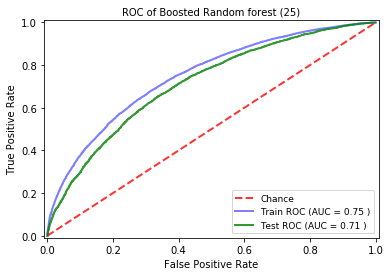

For Train Data:

Confusion Matrix:
 [[9670 4340]
 [4491 9249]]
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.69      0.69     14010
           1       0.68      0.67      0.68     13740

    accuracy                           0.68     27750
   macro avg       0.68      0.68      0.68     27750
weighted avg       0.68      0.68      0.68     27750


 For Test Data:

Confusion Matrix:
 [[4056 2016]
 [2052 3770]]
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.67      0.67      6072
           1       0.65      0.65      0.65      5822

    accuracy                           0.66     11894
   macro avg       0.66      0.66      0.66     11894
weighted avg       0.66      0.66      0.66     11894



ROC_AUC            ACCURACY            \
                                  Train      Test     Train      Test   
Tuned Random Forest            0.730784  0.699953  0.672072  0.645704   
Tuned Decision Tree            0.707696  0.682846  0.651171  0.630990   
Boosted Decision Tree (Tuned)  0.733190  0.700118  0.669333  0.643266   
Boosted Random forest (Tuned)  0.753678  0.720130  0.686523  0.658735   
Gradient Boost (Tuned)         0.750584  0.718745  0.683568  0.659828   
Boosted Random forest (20)     0.745175  0.711391  0.677514  0.656550   
Gradient Boost (20)            0.744065  0.717145  0.679063  0.657811   
Boosted Random forest (25)     0.748298  0.713061  0.681766  0.657979   

                              PRECISION              RECALL            
                                  Train      Test     Train      Test  
Tuned Random Forest            0.670764  0.641053  0.663246  0.627619  
Tuned Decision Tree            0.634598  0.610486  0.696579  0.680007  
Boosted Decision Tree (Tuned)  0.666278  0.634980  0.665502  0.637925  
Boosted Random forest (Tuned)  0.686193  0.652746  0.676055  0.647029  
Gradient Boost (Tuned)         0.684665  0.654596  0.669068  0.645826  
Boosted Random forest (20)     0.676620  0.649974  0.667904  0.646513  
Gradient Boost (20)            0.679997  0.651978  0.664556  0.645483  
Boosted Random forest (25)     0.680624  0.651573  0.673144  0.647544

In [56]:

tuned_AB_RF = AdaBoostClassifier(base_estimator = RF, n_estimators = 15, random_state = 0) 

models = []
models.append(('Boosted Random forest (25)', tuned_AB_RF))

fit_predict_plot(train, test, y_train, y_test, models) # implementing the model

In [ ]:
## RF TOP 30

In [92]:
trf_top30 = ['kw_max_avg', 'kw_min_avg', 'self_reference_min_shares', 'LDA_00', 'n_unique_tokens', 'self_reference_max_shares', 'global_subjectivity', 'is_weekend', 'num_hrefs', 'LDA_01', 'kw_avg_max', 'LDA_04', 'kw_max_min', 'n_tokens_content', 'kw_min_min', 'global_sentiment_polarity', 'LDA_03', 'rate_positive_words', 'global_rate_positive_words', 'num_imgs', 'data_channel_is_entertainment', 'average_token_length', 'avg_positive_polarity', 'title_sentiment_polarity', 'kw_min_max', 'global_rate_negative_words', 'min_positive_polarity', 'data_channel_is_tech', 'num_self_hrefs', 'rate_negative_words']

In [93]:
len(trf_top30)

30

In [94]:
X = df[trf_top30]

Y = df['class']

X_train, X_test, y_train, y_test = perform_train_test_split(X,Y,0.3) # splitting the dataset

train, test = std_data(X_train, X_test) # standardizing the train and test sets

X.shape, X_train.shape

((39644, 30), (27750, 30))

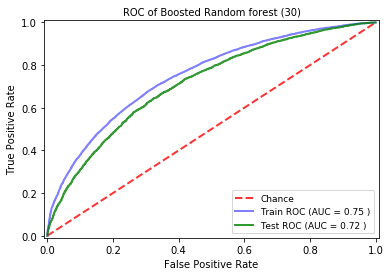

For Train Data:

Confusion Matrix:
 [[9710 4300]
 [4432 9308]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.69      0.69     14010
           1       0.68      0.68      0.68     13740

    accuracy                           0.69     27750
   macro avg       0.69      0.69      0.69     27750
weighted avg       0.69      0.69      0.69     27750


 For Test Data:

Confusion Matrix:
 [[4049 2023]
 [2047 3775]]
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.67      0.67      6072
           1       0.65      0.65      0.65      5822

    accuracy                           0.66     11894
   macro avg       0.66      0.66      0.66     11894
weighted avg       0.66      0.66      0.66     11894



ROC_AUC            ACCURACY            \
                                  Train      Test     Train      Test   
Tuned Random Forest            0.730784  0.699953  0.672072  0.645704   
Tuned Decision Tree            0.707696  0.682846  0.651171  0.630990   
Boosted Decision Tree (Tuned)  0.733190  0.700118  0.669333  0.643266   
Boosted Random forest (Tuned)  0.753678  0.720130  0.686523  0.658735   
Gradient Boost (Tuned)         0.750584  0.718745  0.683568  0.659828   
Boosted Random forest (30)     0.751201  0.715514  0.685333  0.657811   

                              PRECISION              RECALL            
                                  Train      Test     Train      Test  
Tuned Random Forest            0.670764  0.641053  0.663246  0.627619  
Tuned Decision Tree            0.634598  0.610486  0.696579  0.680007  
Boosted Decision Tree (Tuned)  0.666278  0.634980  0.665502  0.637925  
Boosted Random forest (Tuned)  0.686193  0.652746  0.676055  0.647029  
Gradient Boost (Tuned)         0.684665  0.654596  0.669068  0.645826  
Boosted Random forest (30)     0.684009  0.651087  0.677438  0.648403

In [95]:
tuned_AB_RF = AdaBoostClassifier(base_estimator = RF, n_estimators = 15, random_state = 0) 

models = []
models.append(('Boosted Random forest (30)', tuned_AB_RF))

fit_predict_plot(train, test, y_train, y_test, models) # implementing the model

In [ ]:
## GB TOP 20

In [28]:
tgb_top20 = ['kw_max_avg', 'self_reference_min_shares', 'is_weekend', 'kw_min_avg', 'data_channel_is_entertainment', 'data_channel_is_tech', 'data_channel_is_world', 'n_unique_tokens', 'self_reference_max_shares', 'kw_min_min', 'LDA_00', 'num_hrefs', 'data_channel_is_socmed', 'min_positive_polarity', 'LDA_04', 'global_subjectivity', 'num_imgs', 'n_tokens_content', 'LDA_01', 'kw_max_min']

In [29]:
X = df[tgb_top20]

Y = df['class']

X_train, X_test, y_train, y_test = perform_train_test_split(X,Y,0.3) # splitting the dataset

train, test = std_data(X_train, X_test) # standardizing the train and test sets

X.shape, X_train.shape

((39644, 20), (27750, 20))

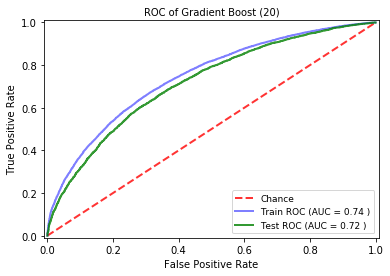

For Train Data:

Confusion Matrix:
 [[9713 4297]
 [4609 9131]]
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.69      0.69     14010
           1       0.68      0.66      0.67     13740

    accuracy                           0.68     27750
   macro avg       0.68      0.68      0.68     27750
weighted avg       0.68      0.68      0.68     27750


 For Test Data:

Confusion Matrix:
 [[4066 2006]
 [2064 3758]]
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.67      0.67      6072
           1       0.65      0.65      0.65      5822

    accuracy                           0.66     11894
   macro avg       0.66      0.66      0.66     11894
weighted avg       0.66      0.66      0.66     11894



ROC_AUC            ACCURACY            \
                                  Train      Test     Train      Test   
Tuned Random Forest            0.730784  0.699953  0.672072  0.645704   
Tuned Decision Tree            0.707696  0.682846  0.651171  0.630990   
Boosted Decision Tree (Tuned)  0.733190  0.700118  0.669333  0.643266   
Boosted Random forest (Tuned)  0.745175  0.711391  0.677514  0.656550   
Gradient Boost (Tuned)         0.750584  0.718745  0.683568  0.659828   
Boosted Random forest (20)     0.745175  0.711391  0.677514  0.656550   
Gradient Boost (20)            0.744065  0.717145  0.679063  0.657811   

                              PRECISION              RECALL            
                                  Train      Test     Train      Test  
Tuned Random Forest            0.670764  0.641053  0.663246  0.627619  
Tuned Decision Tree            0.634598  0.610486  0.696579  0.680007  
Boosted Decision Tree (Tuned)  0.666278  0.634980  0.665502  0.637925  
Boosted Random forest (Tuned)  0.676620  0.649974  0.667904  0.646513  
Gradient Boost (Tuned)         0.684665  0.654596  0.669068  0.645826  
Boosted Random forest (20)     0.676620  0.649974  0.667904  0.646513  
Gradient Boost (20)            0.679997  0.651978  0.664556  0.645483

In [30]:
tuned_GB = GradientBoostingClassifier(n_estimators = 100,learning_rate = 0.1, max_depth = 3, 
                                min_samples_split = 10, min_samples_leaf = 20, random_state = 0)

models = []
models.append(('Gradient Boost (20)',tuned_GB))

fit_predict_plot(train,test,y_train,y_test,models)

In [ ]:
## GB TOP 25

In [57]:
tgb_top25 = ['kw_max_avg', 'self_reference_min_shares', 'is_weekend', 'kw_min_avg', 'data_channel_is_entertainment', 'data_channel_is_tech', 'data_channel_is_world', 'n_unique_tokens', 'self_reference_max_shares', 'kw_min_min', 'LDA_00', 'num_hrefs', 'data_channel_is_socmed', 'min_positive_polarity', 'LDA_04', 'global_subjectivity', 'num_imgs', 'n_tokens_content', 'LDA_01', 'kw_max_min', 'title_sentiment_polarity', 'kw_avg_max', 'global_rate_positive_words', 'rate_positive_words', 'title_subjectivity']

In [58]:
len(tgb_top25)

25

In [59]:
X = df[tgb_top25]

Y = df['class']

X_train, X_test, y_train, y_test = perform_train_test_split(X,Y,0.3) # splitting the dataset

train, test = std_data(X_train, X_test) # standardizing the train and test sets

X.shape, X_train.shape

((39644, 25), (27750, 25))

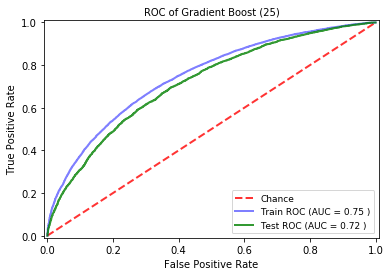

For Train Data:

Confusion Matrix:
 [[9728 4282]
 [4578 9162]]
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.69      0.69     14010
           1       0.68      0.67      0.67     13740

    accuracy                           0.68     27750
   macro avg       0.68      0.68      0.68     27750
weighted avg       0.68      0.68      0.68     27750


 For Test Data:

Confusion Matrix:
 [[4059 2013]
 [2082 3740]]
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.67      0.66      6072
           1       0.65      0.64      0.65      5822

    accuracy                           0.66     11894
   macro avg       0.66      0.66      0.66     11894
weighted avg       0.66      0.66      0.66     11894



ROC_AUC            ACCURACY            \
                                  Train      Test     Train      Test   
Tuned Random Forest            0.730784  0.699953  0.672072  0.645704   
Tuned Decision Tree            0.707696  0.682846  0.651171  0.630990   
Boosted Decision Tree (Tuned)  0.733190  0.700118  0.669333  0.643266   
Boosted Random forest (Tuned)  0.753678  0.720130  0.686523  0.658735   
Gradient Boost (Tuned)         0.750584  0.718745  0.683568  0.659828   
Boosted Random forest (20)     0.745175  0.711391  0.677514  0.656550   
Gradient Boost (20)            0.744065  0.717145  0.679063  0.657811   
Boosted Random forest (25)     0.748298  0.713061  0.681766  0.657979   
Gradient Boost (25)            0.746766  0.717162  0.680721  0.655709   

                              PRECISION              RECALL            
                                  Train      Test     Train      Test  
Tuned Random Forest            0.670764  0.641053  0.663246  0.627619  
Tuned Decision Tree            0.634598  0.610486  0.696579  0.680007  
Boosted Decision Tree (Tuned)  0.666278  0.634980  0.665502  0.637925  
Boosted Random forest (Tuned)  0.686193  0.652746  0.676055  0.647029  
Gradient Boost (Tuned)         0.684665  0.654596  0.669068  0.645826  
Boosted Random forest (20)     0.676620  0.649974  0.667904  0.646513  
Gradient Boost (20)            0.679997  0.651978  0.664556  0.645483  
Boosted Random forest (25)     0.680624  0.651573  0.673144  0.647544  
Gradient Boost (25)            0.681494  0.650096  0.666812  0.642391

In [60]:
tuned_GB = GradientBoostingClassifier(n_estimators = 100,learning_rate = 0.1, max_depth = 3, 
                                min_samples_split = 10, min_samples_leaf = 20, random_state = 0)

models = []
models.append(('Gradient Boost (25)',tuned_GB))

fit_predict_plot(train,test,y_train,y_test,models)

In [ ]:
## GB TOP 30

In [96]:
tgb_top30 = ['kw_max_avg', 'self_reference_min_shares', 'is_weekend', 'kw_min_avg', 'data_channel_is_entertainment', 'data_channel_is_tech', 'data_channel_is_world', 'n_unique_tokens', 'self_reference_max_shares', 'kw_min_min', 'LDA_00', 'num_hrefs', 'data_channel_is_socmed', 'min_positive_polarity', 'LDA_04', 'global_subjectivity', 'num_imgs', 'n_tokens_content', 'LDA_01', 'kw_max_min', 'title_sentiment_polarity', 'kw_avg_max', 'global_rate_positive_words', 'rate_positive_words', 'title_subjectivity', 'global_rate_negative_words', 'average_token_length', 'LDA_03', 'avg_positive_polarity', 'num_self_hrefs']

In [97]:
X = df[tgb_top30]

Y = df['class']

X_train, X_test, y_train, y_test = perform_train_test_split(X,Y,0.3) # splitting the dataset

train, test = std_data(X_train, X_test) # standardizing the train and test sets

X.shape, X_train.shape

((39644, 30), (27750, 30))

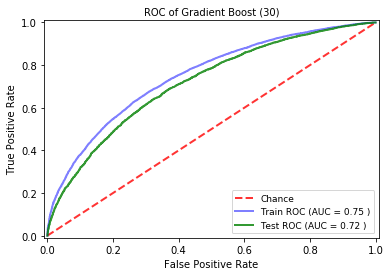

For Train Data:

Confusion Matrix:
 [[9755 4255]
 [4548 9192]]
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.70      0.69     14010
           1       0.68      0.67      0.68     13740

    accuracy                           0.68     27750
   macro avg       0.68      0.68      0.68     27750
weighted avg       0.68      0.68      0.68     27750


 For Test Data:

Confusion Matrix:
 [[4075 1997]
 [2069 3753]]
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.67      0.67      6072
           1       0.65      0.64      0.65      5822

    accuracy                           0.66     11894
   macro avg       0.66      0.66      0.66     11894
weighted avg       0.66      0.66      0.66     11894



ROC_AUC            ACCURACY            \
                                  Train      Test     Train      Test   
Tuned Random Forest            0.730784  0.699953  0.672072  0.645704   
Tuned Decision Tree            0.707696  0.682846  0.651171  0.630990   
Boosted Decision Tree (Tuned)  0.733190  0.700118  0.669333  0.643266   
Boosted Random forest (Tuned)  0.753678  0.720130  0.686523  0.658735   
Gradient Boost (Tuned)         0.750584  0.718745  0.683568  0.659828   
Boosted Random forest (30)     0.751201  0.715514  0.685333  0.657811   
Gradient Boost (30)            0.748634  0.716177  0.682775  0.658147   

                              PRECISION              RECALL            
                                  Train      Test     Train      Test  
Tuned Random Forest            0.670764  0.641053  0.663246  0.627619  
Tuned Decision Tree            0.634598  0.610486  0.696579  0.680007  
Boosted Decision Tree (Tuned)  0.666278  0.634980  0.665502  0.637925  
Boosted Random forest (Tuned)  0.686193  0.652746  0.676055  0.647029  
Gradient Boost (Tuned)         0.684665  0.654596  0.669068  0.645826  
Boosted Random forest (30)     0.684009  0.651087  0.677438  0.648403  
Gradient Boost (30)            0.683573  0.652696  0.668996  0.644624

In [98]:
tuned_GB = GradientBoostingClassifier(n_estimators = 100,learning_rate = 0.1, max_depth = 3, 
                                min_samples_split = 10, min_samples_leaf = 20, random_state = 0)

models = []
models.append(('Gradient Boost (30)',tuned_GB))

fit_predict_plot(train,test,y_train,y_test,models)

## Stacking the Boosted Tuned models

- AB_DT, AB_RF, GB

In [35]:
from sklearn.ensemble import VotingClassifier

tuned_AB_DT = AdaBoostClassifier(base_estimator = DT, n_estimators = 12, random_state = 0) 

tuned_AB_RF = AdaBoostClassifier(base_estimator = RF, n_estimators = 15, random_state = 0) 

tuned_GB = GradientBoostingClassifier(n_estimators = 100,learning_rate = 0.1, max_depth = 3, 
                                min_samples_split = 10, min_samples_leaf = 20, random_state = 0)


clf = VotingClassifier(estimators=[('abdt',tuned_AB_DT), ('abrf',tuned_AB_RF), ('gb',tuned_GB)], voting='soft')

clf.fit(train, y_train)
y_pred_train = clf.predict(train)
y_prob_train = clf.predict_proba(train)[:,1]

y_pred = clf.predict(test)
y_prob = clf.predict_proba(test)[:,1]

print('Accuracy of Stacked Algos-Train: ', accuracy_score(y_pred_train, y_train))
print('Accuracy of Stacked Algos-Test: ', accuracy_score(y_pred, y_test))

print('AUC of Stacked Algos: ', roc_auc_score(y_train, y_prob_train))
print('AUC of Stacked Algos: ', roc_auc_score(y_test, y_prob))

Accuracy of Stacked Algos-Train:  0.6833513513513514
Accuracy of Stacked Algos-Test:  0.6592399529174373
AUC of Stacked Algos:  0.751497578668595
AUC of Stacked Algos:  0.7190204718461481


Stacked AB_DT, AB_RF, GB:

Accuracy of Stacked Algos-Train:  0.6833513513513514
Accuracy of Stacked Algos-Test:  0.6592399529174373
AUC of Stacked Algos:  0.751497578668595
AUC of Stacked Algos:  0.7190204718461481

## Stacking AB_RF GB

In [113]:
from sklearn.ensemble import VotingClassifier

Accuracy of Stacked Algos-Train:  0.6833873873873874
Accuracy of Stacked Algos-Test:  0.6601647889692281
AUC of Stacked Algos:  0.7510852821908244
AUC of Stacked Algos:  0.719081035588511
Classification Report-Train:
                precision    recall  f1-score   support

           0       0.70      0.68      0.69     14324
           1       0.67      0.68      0.68     13426

    accuracy                           0.68     27750
   macro avg       0.68      0.68      0.68     27750
weighted avg       0.68      0.68      0.68     27750

Classification Report-Test:
                precision    recall  f1-score   support

           0       0.67      0.67      0.67      6144
           1       0.65      0.65      0.65      5750

    accuracy                           0.66     11894
   macro avg       0.66      0.66      0.66     11894
weighted avg       0.66      0.66      0.66     11894



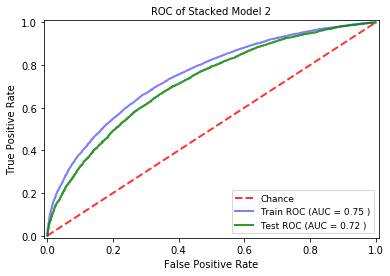

In [117]:
tuned_AB_RF = AdaBoostClassifier(base_estimator = RF, n_estimators = 15, random_state = 0) 

tuned_GB = GradientBoostingClassifier(n_estimators = 100,learning_rate = 0.1, max_depth = 3, 
                                min_samples_split = 10, min_samples_leaf = 20, random_state = 0)


clf = VotingClassifier(estimators=[('abrf',tuned_AB_RF), ('gb',tuned_GB)], voting='soft')

clf.fit(train, y_train)
y_pred_train = clf.predict(train)
y_prob_train = clf.predict_proba(train)[:,1]

y_pred = clf.predict(test)
y_prob = clf.predict_proba(test)[:,1]

print('Accuracy of Stacked Algos-Train: ', accuracy_score(y_pred_train, y_train))
print('Accuracy of Stacked Algos-Test: ', accuracy_score(y_pred, y_test))

print('AUC of Stacked Algos: ', roc_auc_score(y_train, y_prob_train))
print('AUC of Stacked Algos: ', roc_auc_score(y_test, y_prob))

print('Classification Report-Train:\n ', classification_report(y_pred_train, y_train))
print('Classification Report-Test:\n ', classification_report(y_pred, y_test))

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_prob_train)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_prob)

        
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.plot(fpr_train, tpr_train, color='b', 
                 label=r'Train ROC (AUC = %0.2f )' % (roc_auc_score(y_train, y_prob_train)),lw=2, alpha=.5)
plt.plot(fpr_test, tpr_test, color='g', 
                 label=r'Test ROC (AUC = %0.2f )' % (roc_auc_score(y_test, y_prob)),lw=2, alpha=.8)

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('ROC of Stacked Model 2',fontsize=10)
plt.legend(loc="lower right", prop={'size': 9})
plt.show()

-- stacked AB_RF, GB

Accuracy of Stacked Algos-Train:  0.6833873873873874
Accuracy of Stacked Algos-Test:  0.6601647889692281
AUC of Stacked Algos:  0.7510852821908244
AUC of Stacked Algos:  0.719081035588511

## Stacking tuned DT and RF

In [41]:
rf_param =  {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 9}

tuned_RF = RandomForestClassifier(**rf_param, random_state = 0)


dt_param = {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 9} 

tuned_DT = DecisionTreeClassifier(**dt_param, random_state = 0)


clf = VotingClassifier(estimators=[('TRF',tuned_RF), ('TDT',tuned_DT)], voting='soft')

clf.fit(train, y_train)
y_pred_train = clf.predict(train)
y_prob_train = clf.predict_proba(train)[:,1]

y_pred = clf.predict(test)
y_prob = clf.predict_proba(test)[:,1]

print('Accuracy of Stacked Algos-Train: ', accuracy_score(y_pred_train, y_train))
print('Accuracy of Stacked Algos-Test: ', accuracy_score(y_pred, y_test))

print('AUC of Stacked Algos: ', roc_auc_score(y_train, y_prob_train))
print('AUC of Stacked Algos: ', roc_auc_score(y_test, y_prob))

Accuracy of Stacked Algos-Train:  0.6692972972972973
Accuracy of Stacked Algos-Test:  0.6454514881452833
AUC of Stacked Algos:  0.7281528945326015
AUC of Stacked Algos:  0.6991165274690658


Stacking tuned DT and RF

Accuracy of Stacked Algos-Train:  0.6692972972972973
Accuracy of Stacked Algos-Test:  0.6454514881452833
AUC of Stacked Algos:  0.7281528945326015
AUC of Stacked Algos:  0.6991165274690658

## SVM

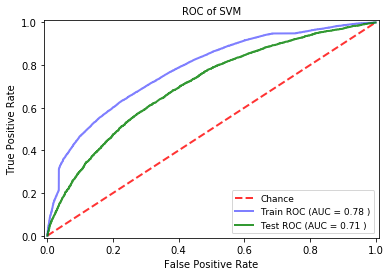

For Train Data:

Confusion Matrix:
 [[10144  3866]
 [ 4428  9312]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.72      0.71     14010
           1       0.71      0.68      0.69     13740

    accuracy                           0.70     27750
   macro avg       0.70      0.70      0.70     27750
weighted avg       0.70      0.70      0.70     27750


 For Test Data:

Confusion Matrix:
 [[4058 2014]
 [2170 3652]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.67      0.66      6072
           1       0.64      0.63      0.64      5822

    accuracy                           0.65     11894
   macro avg       0.65      0.65      0.65     11894
weighted avg       0.65      0.65      0.65     11894



,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
SVM (Tuned),0.680364,0.671472,0.604829,0.597108,0.582168,0.570742,0.715211,0.713672
SVM,0.781061,0.705066,0.701117,0.648226,0.706632,0.644546,0.677729,0.627276


In [16]:
SVM = svm.SVC(kernel = 'rbf', gamma = 'auto', probability = True, random_state = 0)

models = []
models.append(('SVM',SVM))

fit_predict_plot(train,test,y_train,y_test,models)

## Tuned SVM 

In [11]:
from sklearn import svm

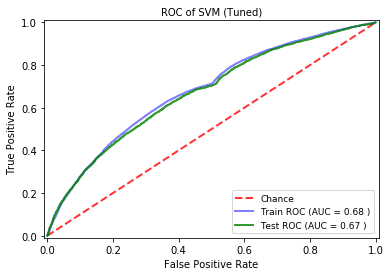

For Train Data:

Confusion Matrix:
 [[6957 7053]
 [3913 9827]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.50      0.56     14010
           1       0.58      0.72      0.64     13740

    accuracy                           0.60     27750
   macro avg       0.61      0.61      0.60     27750
weighted avg       0.61      0.60      0.60     27750


 For Test Data:

Confusion Matrix:
 [[2947 3125]
 [1667 4155]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.49      0.55      6072
           1       0.57      0.71      0.63      5822

    accuracy                           0.60     11894
   macro avg       0.60      0.60      0.59     11894
weighted avg       0.61      0.60      0.59     11894



,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
SVM (Tuned),0.680364,0.671472,0.604829,0.597108,0.582168,0.570742,0.715211,0.713672
SVM,0.781061,0.705066,0.701117,0.648226,0.706632,0.644546,0.677729,0.627276


In [17]:
SVM = svm.SVC(kernel = 'linear', gamma = 'auto', probability = True, random_state = 0)

models = []
models.append(('SVM (Tuned)',SVM))

fit_predict_plot(train,test,y_train,y_test,models)

## Boosting SVM

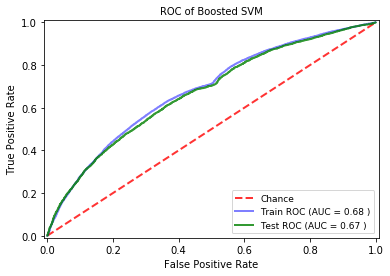

For Train Data:

Confusion Matrix:
 [[6957 7053]
 [3913 9827]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.50      0.56     14010
           1       0.58      0.72      0.64     13740

    accuracy                           0.60     27750
   macro avg       0.61      0.61      0.60     27750
weighted avg       0.61      0.60      0.60     27750


 For Test Data:

Confusion Matrix:
 [[2947 3125]
 [1667 4155]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.49      0.55      6072
           1       0.57      0.71      0.63      5822

    accuracy                           0.60     11894
   macro avg       0.60      0.60      0.59     11894
weighted avg       0.61      0.60      0.59     11894



,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Boosted SVM,0.680364,0.671472,0.604829,0.597108,0.582168,0.570742,0.715211,0.713672


In [12]:
SVM = svm.SVC(kernel = 'linear', gamma = 'auto', probability = True, random_state = 0)

AB_SVM = AdaBoostClassifier(base_estimator = SVM, random_state = 0) 

models = []
models.append(('Boosted SVM', SVM))

fit_predict_plot(train, test, y_train, y_test, models) # implementing the model